In [1]:
# pip install loguru
# ! pip install datasets==3.3.2
# ! pip install loguru==0.7.3
# ! pip install numpy==2.2.3
# ! pip install torch==2.6.0
# ! pip install tqdm==4.67.1
# ! pip install transformers==4.49.0

\begin{array}{c|ccc} 
\hline 
t & a & b & c \\ 
\hline 
\quad 1\quad & 3955/1024 & -8306/1024 & 5008/1024 \\ 
2 & 3735/1024 & -6681/1024 & 3463/1024 \\ 
3 & 3799/1024 & -6499/1024 & 3211/1024 \\ 
4 & 4019/1024 & -6385/1024 & 2906/1024 \\ 
5 & 2677/1024 & -3029/1024 & 1162/1024 \\ 
6 & 2172/1024 & -1833/1024 &  682/1024 \\ 
\hline 
\end{array}
**TODO**: please try to set different a, b and c as above in different iterations for potential better results, you can name it `zeropower_via_newtonschulz6'

In [8]:
import torch.nn as nn
import torch
import torch.optim as optim


def zeropower_via_newtonschulz5(G, steps: int):
    """
    Newton-Schulz iteration to compute the zeroth power / orthogonalization of G. We opt to use a
    quintic iteration whose coefficients are selected to maximize the slope at zero. For the purpose
    of minimizing steps, it turns out to be empirically effective to keep increasing the slope at
    zero even beyond the point where the iteration no longer converges all the way to one everywhere
    on the interval. This iteration therefore does not produce UV^T but rather something like US'V^T
    where S' is diagonal with S_{ii}' ~ Uniform(0.5, 1.5), which turns out not to hurt model
    performance at all relative to UV^T, where USV^T = G is the SVD.
    """
    
    assert G.ndim >= 2 # batched Muon implementation by @scottjmaddox, and put into practice in the record by @YouJiacheng
    
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    if G.size(-2) > G.size(-1):
        X = X.mT

    # Ensure spectral norm is at most 1
    X = X / (X.norm(dim=(-2, -1), keepdim=True) + 1e-7)
    # Perform the NS iterations
    for _ in range(steps):
        A = X @ X.mT
        B = b * A + c * A @ A # quintic computation strategy adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
        X = a * X + B @ X

    if G.size(-2) > G.size(-1):
        X = X.mT
    return X

#check https://docs.pytorch.org/docs/stable/generated/torch.optim.Muon.html 
def muon_update(grad, momentum, beta=0.95, ns_steps=5, nesterov=True):
    #TODO: momentum = beta * momentum +  grad
    
    #TODO: nesterov may be applied for acceleration
    
    

    if update.ndim == 4:  # for the case of conv filters
        update = update.view(update.shape[0], -1)  # keep first dim, flatten the rest

    update = zeropower_via_newtonschulz5(update, steps=ns_steps)
    update *= max(1, grad.size(-2) / grad.size(-1))**0.5
    return update


class Muon(optim.Optimizer):
    def __init__(self, params, lr=0.01, momentum=0.95, steps=5,
                 weight_decay=0, nesterov=True, maximize=False):

        defaults = dict(lr=lr, momentum=momentum, steps=steps,
                        weight_decay=weight_decay, nesterov=nesterov)
        self.maximize = maximize
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group['lr']
            momentum = group['momentum']
            steps = group['steps']
            weight_decay = group['weight_decay']
            nesterov = group['nesterov']


            for p in group['params']:
                if p.grad is None:
                    continue

                if self.maximize:
                    grad = -p.grad
                else:
                    grad = p.grad

                # Get state for this parameter
                state = self.state[p]
                # Initialize momentum buffer if it doesn't exist
                if 'momentum_buffer' not in state:
                    state['momentum_buffer'] = torch.zeros_like(grad)

                # Apply weight decay directly to parameters (AdamW style)
                if weight_decay != 0:
                    p.mul_(1 - lr * weight_decay)

                # Apply zeropower_via_newtonschulz5 if parameter is a matrix
                if p.ndim >= 2:
                    org_shape = p.shape
                    orthogonal_buff = muon_update(grad, state["momentum_buffer"],
                                                beta=momentum, ns_steps=steps, nesterov=nesterov)
                    if p.ndim == 4:
                        orthogonal_buff = orthogonal_buff.view(org_shape)

                    # Apply update to parameters
                    p.add_(orthogonal_buff, alpha=-lr)
                else:
                    # For non-matrix parameters, use standard momentum update
                    buf = state['momentum_buffer']
                    buf.mul_(momentum).add_(grad)

                    # furhter modify buf if nesterov
                    if nesterov:
                        buf = grad + momentum * buf

                    # Apply update to parameters
                    p.add_(buf, alpha=-lr)

        return loss


--- Training with Muon ---
Muon | Epoch 1, avg loss: 0.2745, time: 3.84 seconds
Muon | Epoch 2, avg loss: 0.0679, time: 3.71 seconds
Muon | Epoch 3, avg loss: 0.0499, time: 3.75 seconds
Muon | Total training time: 11.30 seconds

--- Training with SGD ---
SGD | Epoch 1, avg loss: 1.7152, time: 2.81 seconds
SGD | Epoch 2, avg loss: 0.5359, time: 2.75 seconds
SGD | Epoch 3, avg loss: 0.3849, time: 2.77 seconds
SGD | Total training time: 8.33 seconds

--- Training with AdamW ---
AdamW | Epoch 1, avg loss: 0.2805, time: 2.98 seconds
AdamW | Epoch 2, avg loss: 0.1039, time: 2.96 seconds
AdamW | Epoch 3, avg loss: 0.0698, time: 2.97 seconds
AdamW | Total training time: 8.91 seconds


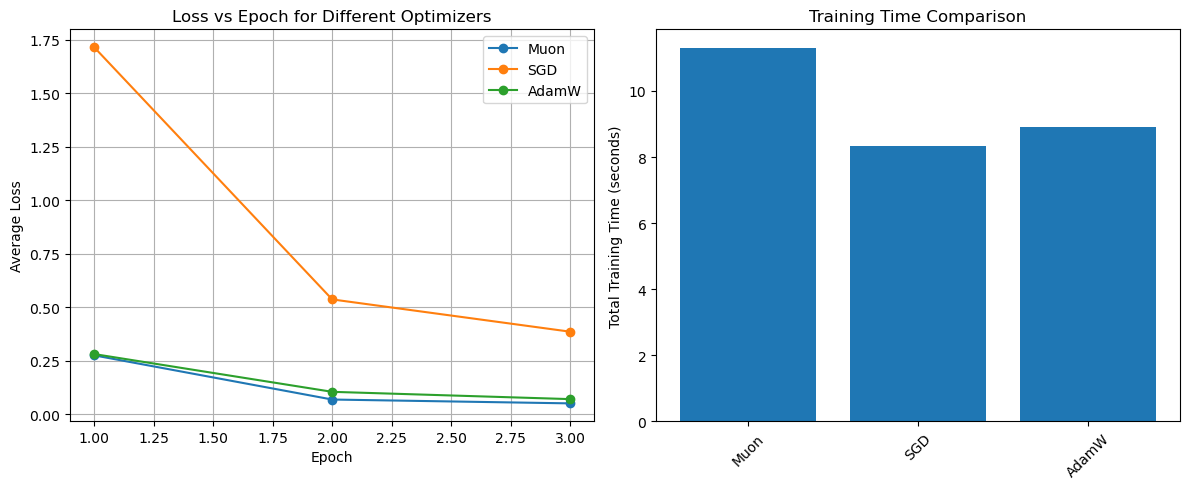


--- Performance Summary ---
Optimizer | Final Loss | Total Time (s) | Relative Speed
Muon         | 0.0499     | 11.30          | 1.36x
SGD          | 0.3849     | 8.33          | 1.00x
AdamW        | 0.0698     | 8.91          | 1.07x


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time  # Import time module for timing

# --- your optimizer import here ---
# from muon import Muon

# Simple MLP for MNIST
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Dataset & loader
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

# --- Define the optimizers you want to compare ---
optimizers_dict = {
    "Muon": lambda params: Muon(params, lr=1e-2),
    #"OptimizedMuon": lambda params: OptimizedMuon(params, lr=1e-2),
    "SGD": lambda params: torch.optim.SGD(params, lr=1e-2),
    "AdamW": lambda params: torch.optim.AdamW(params, lr=0.001, weight_decay=0.01),
}

results = {}  # store loss curves
time_results = {}  # store timing information

for opt_name, opt_fn in optimizers_dict.items():
    print(f"\n--- Training with {opt_name} ---")
    model = MLP().to(device)  # re-init model each time
    optimizer = opt_fn(model.parameters())

    losses = []
    epoch_times = []

    for epoch in range(1, 4):  # just 3 epochs to test
        epoch_start_time = time.time()
        total_loss = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"{opt_name} | Epoch {epoch}, avg loss: {avg_loss:.4f}, time: {epoch_duration:.2f} seconds")

    results[opt_name] = losses
    time_results[opt_name] = epoch_times

    # Calculate and print total training time
    total_time = sum(epoch_times)
    print(f"{opt_name} | Total training time: {total_time:.2f} seconds")

# --- Plot results ---
# 1. Loss vs Epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
for opt_name, losses in results.items():
    plt.plot(range(1, len(losses)+1), losses, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Loss vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

# 2. Time vs Optimizer
plt.subplot(1, 2, 2)
opt_names = list(time_results.keys())
total_times = [sum(times) for times in time_results.values()]
plt.bar(opt_names, total_times)
plt.ylabel("Total Training Time (seconds)")
plt.title("Training Time Comparison")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Also print a summary table
print("\n--- Performance Summary ---")
print("Optimizer | Final Loss | Total Time (s) | Relative Speed")
fastest_time = min(total_times)
for i, opt_name in enumerate(opt_names):
    final_loss = results[opt_name][-1]
    total_time = total_times[i]
    relative_speed = total_time / fastest_time
    print(f"{opt_name:12} | {final_loss:.4f}     | {total_time:.2f}          | {relative_speed:.2f}x")

Files already downloaded and verified
Files already downloaded and verified

--- Training with Muon ---
Epoch [1/5], Step [100/391], Loss: 1.6444
Epoch [1/5], Step [200/391], Loss: 1.3081
Epoch [1/5], Step [300/391], Loss: 1.2333
Muon | Epoch 1, avg loss: 1.4174, test acc: 67.01%, time: 4.28 seconds
Epoch [2/5], Step [100/391], Loss: 0.9701
Epoch [2/5], Step [200/391], Loss: 1.0290
Epoch [2/5], Step [300/391], Loss: 0.9246
Muon | Epoch 2, avg loss: 0.9472, test acc: 75.02%, time: 3.49 seconds
Epoch [3/5], Step [100/391], Loss: 0.9825
Epoch [3/5], Step [200/391], Loss: 0.8174
Epoch [3/5], Step [300/391], Loss: 0.8662
Muon | Epoch 3, avg loss: 0.7978, test acc: 76.39%, time: 3.51 seconds
Epoch [4/5], Step [100/391], Loss: 0.6243
Epoch [4/5], Step [200/391], Loss: 0.6237
Epoch [4/5], Step [300/391], Loss: 0.6742
Muon | Epoch 4, avg loss: 0.6886, test acc: 80.20%, time: 3.51 seconds
Epoch [5/5], Step [100/391], Loss: 0.6297
Epoch [5/5], Step [200/391], Loss: 0.5510
Epoch [5/5], Step [300/3

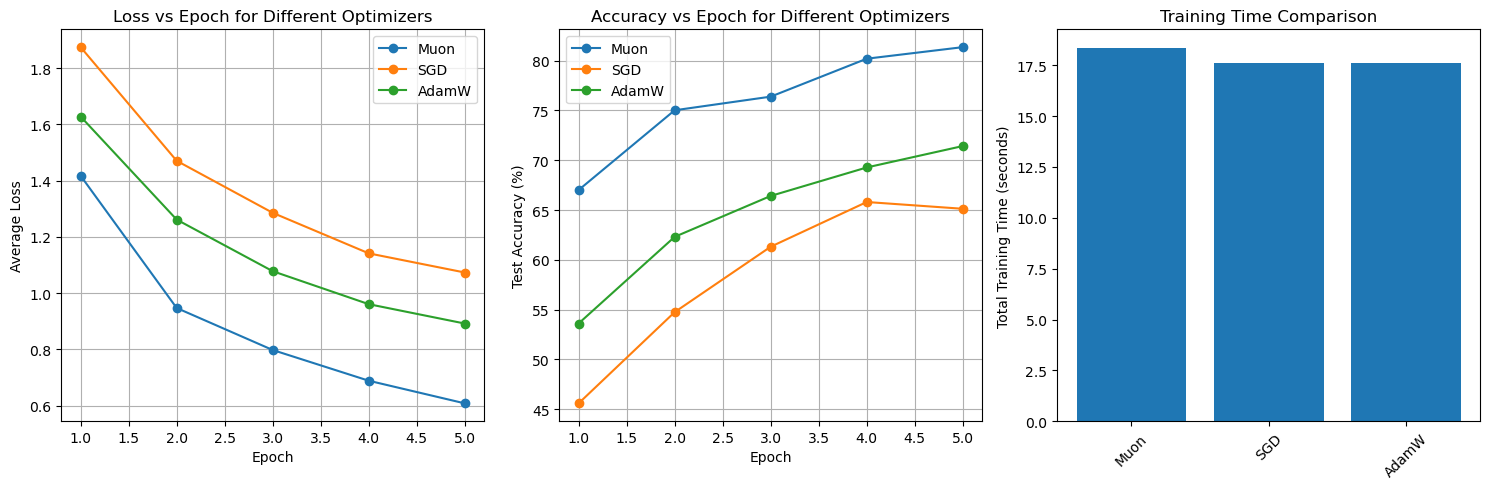


--- Performance Summary ---
Optimizer | Final Loss | Final Acc (%) | Total Time (s) | Relative Speed
Muon         | 0.6081     | 81.36        | 18.35          | 1.04x
SGD          | 1.0733     | 65.13        | 17.59          | 1.00x
AdamW        | 0.8919     | 71.43        | 17.64          | 1.00x


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# Import your optimizers
# from muon import Muon, OptimizedMuon

# Define a more substantial CNN for CIFAR-10
class CIFAR10CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Dataset & loader with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Increase batch size for more realistic training
batch_size = 128

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)

test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2)

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion = nn.CrossEntropyLoss()

# Function to evaluate model
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# --- Define the optimizers you want to compare ---
optimizers_dict = {
    "Muon": lambda params: Muon(params, lr=1e-2),
    # "OptimizedMuon": lambda params: OptimizedMuon(params, lr=1e-3),
    "SGD": lambda params: torch.optim.SGD(params, lr=1e-2, momentum=0.9, weight_decay=5e-4),
    "AdamW": lambda params: torch.optim.AdamW(params, lr=1e-3, weight_decay=1e-4),
}

results = {}  # store loss curves
accuracy_results = {}  # store accuracy curves
time_results = {}  # store timing information

# --- Train for each optimizer ---
for opt_name, opt_fn in optimizers_dict.items():
    print(f"\n--- Training with {opt_name} ---")
    model = CIFAR10CNN().to(device)  # re-init model each time
    optimizer = opt_fn(model.parameters())

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)

    losses = []
    accuracies = []
    epoch_times = []

    for epoch in range(1, 6):  # Train for 5 epochs
        model.train()
        epoch_start_time = time.time()
        total_loss = 0

        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Print progress
            if (i+1) % 100 == 0:
                print(f'Epoch [{epoch}/5], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        epoch_times.append(epoch_duration)

        # Evaluate
        test_acc = evaluate(model, test_loader)

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        accuracies.append(test_acc)

        print(f"{opt_name} | Epoch {epoch}, avg loss: {avg_loss:.4f}, test acc: {test_acc:.2f}%, time: {epoch_duration:.2f} seconds")

        # Update learning rate
        scheduler.step()

    results[opt_name] = losses
    accuracy_results[opt_name] = accuracies
    time_results[opt_name] = epoch_times

    # Calculate and print total training time
    total_time = sum(epoch_times)
    print(f"{opt_name} | Total training time: {total_time:.2f} seconds")

# --- Plot results ---
# 1. Loss vs Epoch
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
for opt_name, losses in results.items():
    plt.plot(range(1, len(losses)+1), losses, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Loss vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

# 2. Accuracy vs Epoch
plt.subplot(1, 3, 2)
for opt_name, accuracies in accuracy_results.items():
    plt.plot(range(1, len(accuracies)+1), accuracies, label=opt_name, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Accuracy vs Epoch for Different Optimizers")
plt.legend()
plt.grid(True)

# 3. Time vs Optimizer
plt.subplot(1, 3, 3)
opt_names = list(time_results.keys())
total_times = [sum(times) for times in time_results.values()]
plt.bar(opt_names, total_times)
plt.ylabel("Total Training Time (seconds)")
plt.title("Training Time Comparison")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Also print a summary table
print("\n--- Performance Summary ---")
print("Optimizer | Final Loss | Final Acc (%) | Total Time (s) | Relative Speed")
fastest_time = min(total_times)
for i, opt_name in enumerate(opt_names):
    final_loss = results[opt_name][-1]
    final_acc = accuracy_results[opt_name][-1]
    total_time = total_times[i]
    relative_speed = total_time / fastest_time
    print(f"{opt_name:12} | {final_loss:.4f}     | {final_acc:.2f}        | {total_time:.2f}          | {relative_speed:.2f}x")

In [48]:
import torch
import torch.nn as nn
class myselfattention(nn.Module):
    def __init__(self, d_in, d_out,context_length,bias=True):
        super().__init__()
        self.W_value=nn.Linear(d_in,d_out,bias=bias)
        self.W_query=nn.Linear(d_in,d_out,bias=bias)
        self.W_key=nn.Linear(d_in,d_out,bias=bias)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New
    def forward(self, x): 
        _,num_tokens,_=x.shape
        value=self.W_value(x)
        query=self.W_query(x)
        key=self.W_key(x)
        attn_scores=query@key.mT
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)      
        return nn.Softmax(dim=-1)(attn_scores/key.shape[-1]**0.5)@value

In [49]:
class myselfattention_mh(nn.Module):
    def __init__(self, d_in, d_head, d_out,context_length,bias=True):
        super().__init__()
        self.heads=nn.ModuleList([myselfattention(d_in, d_out//d_head, context_length) for _ in range(d_head)])
        self.W_out=nn.Linear(d_out,d_out,bias)
    def forward(self, x): 
        out=torch.cat([self.heads[i](x) for i in range(len(self.heads))], dim=-1)
        return self.W_out(out)

In [50]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(myselfattention_mh(16,8,16,7))

1088

In [51]:
class mySilu(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x): 
        return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2/torch.pi))*(x+0.044715*x**3)))

In [52]:
class ffn(nn.Module):
    def __init__(self,dim,dropout=0.1,bias=True):
        super().__init__()
        self.W1=nn.Linear(dim,4*dim,bias)
        self.W2=nn.Linear(4*dim,dim,bias)
        self.dropout=nn.Dropout(dropout)
        self.silu=mySilu()
    def forward(self, x): 
        return self.dropout(self.W2(self.silu(self.W1(x))))

In [53]:
class myTransformer(nn.Module):
    def __init__(self, heads, dropout, hidden,context_length,bias=True):
        super().__init__()
        self.myselfattention_mh=myselfattention_mh(hidden,heads,hidden,context_length)#nn.ModuleList([myselfattention(d_in, d_head) for _ in range(d_out//d_head)])
        self.layernorm1=nn.LayerNorm(hidden)
        self.layernorm2=nn.LayerNorm(hidden)
        self.ffn=ffn(hidden,dropout,bias)
        self.dropout=dropout
    def forward(self, x): 
        shortcut1=x;
        x=self.layernorm1(x)
        x=self.myselfattention_mh(x)
        x=nn.Dropout(self.dropout)(x)
        x=x+shortcut1
        shortcut2=x;
        x=self.layernorm2(x)
        x=self.ffn(x)
        x=nn.Dropout(self.dropout)(x)
        x=x+shortcut2
        return x

In [54]:
cfg={
    "layers": 12,
    "heads": 12,
    "dropout": 0.1,
    "context_length": 1024,
    "hidden_dim": 768,
    "voc_size": 50257
}
class myGPT2(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers=cfg["layers"]
        self.heads=cfg["heads"]
        self.dropout=cfg["dropout"]
        self.context_length=cfg["context_length"]
        self.hidden_dim=cfg["hidden_dim"]
        self.voc_size=cfg["voc_size"]
        self.wte=nn.Embedding(self.voc_size,self.hidden_dim)
        self.wpe=nn.Embedding(self.context_length,self.hidden_dim)
        self.layernorm=nn.LayerNorm(self.hidden_dim)
        self.linear=nn.Linear(self.hidden_dim,self.voc_size,bias=False)
        self.transformerBlocks=nn.ModuleList([myTransformer(self.heads,self.dropout,self.hidden_dim,self.context_length) for _ in range(self.layers)])
    def forward(self, x): 
        batch,length=x.shape
        te=self.wte(x);
        pe=self.wpe(torch.arange(length, device=x.device));
        x=te+pe;
        x=nn.Dropout(self.dropout)(x)
        x=nn.Sequential(*self.transformerBlocks)(x)
        x=self.layernorm(x)
        x=self.linear(x)
        return x

In [58]:
x=torch.tensor([[1, 2, 3], [4, 5, 6]])
model=myGPT2(cfg)
model(x).shape

torch.Size([2, 3, 50257])

In [59]:
count_parameters(model)

163037184

In [60]:
input_text1="I study at Clemson"
input_text2="I am a student"
input = [input_text1,input_text2]
import tiktoken

# Load GPT-2 tokenizer
enc = tiktoken.get_encoding("gpt2")

tokens = [enc.encode(text) for text in input]

In [61]:
def generate(model,tokens,max_length):
    for i in range(max_length):
        with torch.no_grad():
            x=model(tokens)        
        logits=x[:,-1,:]
        _,idx=torch.max(logits, dim=-1, keepdim=True)
        tokens=torch.cat((tokens, idx), dim=1)
    return tokens
generated=generate(model,torch.tensor(tokens),6)

In [62]:
for i, seq in enumerate(generated.tolist()):
    text = enc.decode(seq)
    print(f"Sequence {i}: {text}")

Sequence 0: I study at Clemson Lore analogy math hurdle Returning Loren
Sequence 1: I am a studentebook → upload tirelessly psychedelic household


In [63]:
import os
import requests

In [64]:
file_path = "small.txt"
with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [65]:
print(text_data[:99])

﻿The Project Gutenberg eBook of Two Centuries of Costume in America, Vol. 1 (1620-1820), by Alice M


In [66]:
total_characters = len(text_data)
total_tokens = len(enc.encode(text_data,disallowed_special=()))


print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 527230
Tokens: 140584


In [67]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=cfg["context_length"],
    stride=cfg["context_length"],
    drop_last=True,
    shuffle=True
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=cfg["context_length"],
    stride=cfg["context_length"],
    drop_last=False,
    shuffle=False
)

In [68]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    break

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)
    break

Train loader:
torch.Size([2, 1024]) torch.Size([2, 1024])

Validation loader:
torch.Size([2, 1024]) torch.Size([2, 1024])


In [69]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 124928
Validation tokens: 13312
All tokens: 138240


In [70]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch=input_batch.to(device)
    target_batch=target_batch.to(device)
    prediction=model(input_batch)
    return torch.nn.functional.cross_entropy(prediction.flatten(0, 1), target_batch.flatten())

In [71]:
def calc_loss_loader(data_loader, model, device,num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            total_loss += calc_loss_batch(input_batch, target_batch, model, device).item()           
        else:
            break
    return total_loss / num_batches

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
torch.manual_seed(123) 
with torch.no_grad(): 
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.988230079901022
Validation loss: 10.986832618713379


In [78]:
from previous_chapters import generate_text_simple
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())
def train_model_simple(model, train_loader, val_loader, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            
            muon_opt.zero_grad()
            adamw_opt.zero_grad()
            
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            
            muon_opt.step()
            adamw_opt.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
        #scheduler.step()
    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.wpe.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [79]:
import time
start_time = time.time()

torch.manual_seed(123)
model = myGPT2(cfg)
model.to(device)

muon_params = []
adamw_params = []
# Please refer to https://kellerjordan.github.io/posts/muon/#empirical-considerations
for name, p in model.named_parameters():

    # 1. Embeddings (token + position)
    if "wte" in name.lower() or "wpe" in name.lower():
        ##TODO: use append function to include p to the right place

    # 2. LayerNorms
    elif "ln" in name.lower() or "layernorm" in name.lower() or "norm" in name.lower():
        ##TODO: use append function to include p to the right place

    # 3. Final projection layer (lm_head), which is named "linear"
    elif "linear" in name.lower() and p.ndim == 2:      
        ##TODO: use append function to include p to the right place

    # 4. Biases and any 1D parameter
    elif p.ndim == 1:
        ##TODO: use append function to include p to the right place

    # 5. True 2D matrices (W_Q, W_K, W_V, W_O, MLP matrices, etc.)
    elif p.ndim == 2:
        ##TODO: use append function to include p to the right place

    else:
        ##TODO: use append function to include p to the right place

print(f"Using Muon for {len(muon_params)} matrices")
print(f"Using AdamW for {len(adamw_params)} parameters (LN, embeddings, LM head, biases)")
muon_opt = Muon(
    muon_params,
    lr=0.03,
    weight_decay=1.2
)

adamw_opt = torch.optim.AdamW(
    adamw_params,
    lr=0.008,
    betas=(0.65, 0.95),
    weight_decay=0.0
)


num_epochs = 4
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=enc
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Using Muon for 468 matrices
Using AdamW for 521 parameters (LN, embeddings, LM head, biases)
Ep 1 (Step 000000): Train loss 9.523, Val loss 9.509
Ep 1 (Step 000005): Train loss 7.426, Val loss 7.864
Ep 1 (Step 000010): Train loss 6.771, Val loss 7.264
Ep 1 (Step 000015): Train loss 6.231, Val loss 7.247
Ep 1 (Step 000020): Train loss 5.439, Val loss 6.943
Ep 1 (Step 000025): Train loss 3.901, Val loss 6.912
Ep 1 (Step 000030): Train loss 5.276, Val loss 7.045
Ep 1 (Step 000035): Train loss 5.213, Val loss 7.023
Ep 1 (Step 000040): Train loss 4.293, Val loss 6.798
Ep 1 (Step 000045): Train loss 4.583, Val loss 6.776
Ep 1 (Step 000050): Train loss 4.656, Val loss 6.808
Ep 1 (Step 000055): Train loss 4.785, Val loss 6.658
Ep 1 (Step 000060): Train loss 4.286, Val loss 6.648
Every effort moves you          The portrait is owned by Miss.       The portrait is owned by Miss.’s portrait is owned by Miss.          
Ep 2 (Step 000065): Train loss 4.170, Val loss 6.785
Ep 2 (Step 000070): Train 